In [217]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scoring as sc
import scheduler as sch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
# read json file patient_config.json
with open('patient_config.json') as f:
    patient_config = json.load(f)
search_from = sch.search_from_dose(patient_config)
doses1 = [1, 0.75, 0.5] if search_from <= 1 else [float(patient_config["d1"])]
doses2 = [1, 0.75, 0.5] if search_from <= 2 else [float(patient_config["d2"])]
doses3 = [1, 0.75, 0.5] if search_from <= 3 else [float(patient_config["d3"])]
doses4 = [1, 0.75, 0.5] if search_from <= 4 else [float(patient_config["d4"])]
plans = [(t1, t2, t3, t4) for t1 in doses1 for t2 in doses2 for t3 in doses3 for t4 in doses4]

In [219]:
start_time = time.time()
print(f"Testing {len(plans)} treatment schedules.")

sols = [sc.score(patient_config, plan) for plan in plans]
sols = [sol for sol in sols if sol is not None]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Found {len(sols)} feasible treatment schedules.")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

Testing 81 treatment schedules.
Found 16 feasible treatment schedules.
Elapsed Time: 17.2316 seconds


In [220]:
scored_plans = [[*sol["plan"], sc.score_burden(sol["burden_sol"]), sc.score_toxicity(sol["toxicity_sol"]), sch.duration(sol["schedule"])] for sol in sols]
df_sp = pd.DataFrame(scored_plans, columns = ["S1", "S2", "S3", "S4", "burden", "toxicity", "total_time"])
df_sp["total_time"] = df_sp["total_time"].astype(int)
df_sp.head()

,S1,S2,S3,S4,burden,toxicity,total_time
0,0.75,0.75,0.75,0.75,534.753603,1.369745,651
1,0.75,0.75,0.75,0.50,1616.420476,1.211984,623
2,0.75,0.75,0.50,0.75,1775.987628,1.251667,616
3,0.75,0.75,0.50,0.50,5168.823575,1.093906,588
4,0.75,0.50,0.75,0.75,2494.516187,1.275283,623


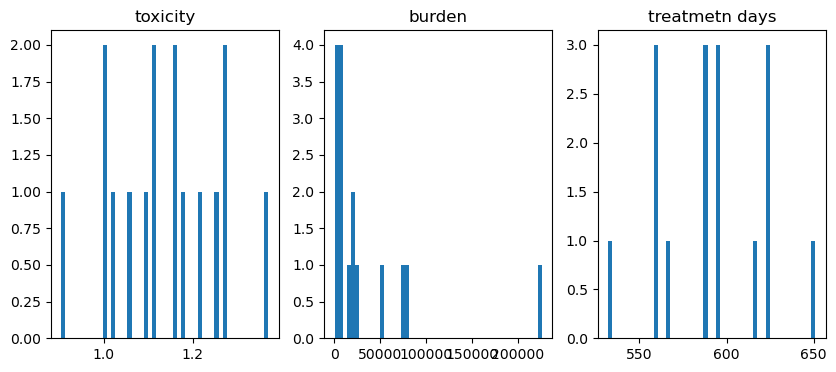

In [221]:
# plot two histograms for cost and benefit
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(df_sp["toxicity"], bins=50)
ax[0].set_title("toxicity");
ax[1].hist(df_sp["burden"], bins=50)
ax[1].set_title("burden");
ax[2].hist(df_sp["total_time"], bins=50)
ax[2].set_title("treatmetn days");

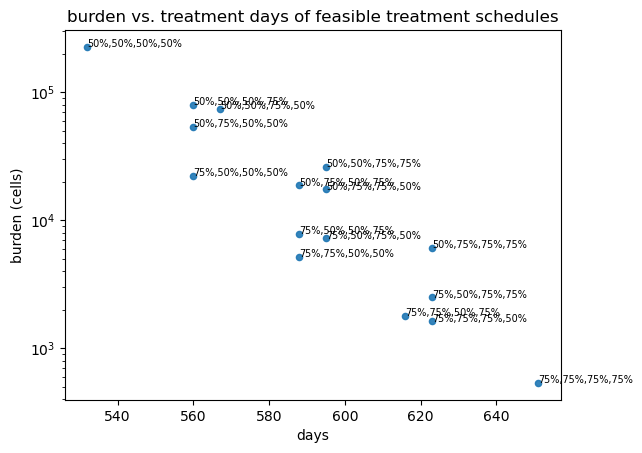

In [222]:
plt.scatter(df_sp["total_time"], df_sp["burden"], s=20, alpha=0.9)

# Add compact labels
for i in range(df_sp.shape[0]):
    values = df_sp.iloc[i][['S1','S2','S3','S4']].values
    label = f"{values[0]:2.0%},{values[1]:2.0%},{values[2]:2.0%},{values[3]:2.0%}"
    plt.text(df_sp.iloc[i]["total_time"], df_sp.iloc[i]["burden"], label, fontsize=7)

# set y to log
plt.yscale("log")
plt.xlabel("days")
plt.ylabel("burden (cells)")
plt.title("burden vs. treatment days of feasible treatment schedules");

In [223]:
time_min = df_sp["total_time"].min()
time_max = df_sp["total_time"].max()
time_range = time_max - time_min
df_sp["time_score"] = 1 - (df_sp["total_time"] - time_min) / time_range

burden_min = np.log(df_sp["burden"].min())
burden_max = np.log(df_sp["burden"].max())
burden_range = burden_max - burden_min
df_sp["burden_score"] = 1- (np.log(df_sp["burden"]) - burden_min) / burden_range

df_sp["score"] = df_sp["time_score"] + df_sp["burden_score"]
df_sp

,S1,S2,S3,S4,burden,toxicity,total_time,time_score,burden_score,score
0,0.75,0.75,0.75,0.75,534.753603,1.369745,651,0.000000,1.000000,1.000000
1,0.75,0.75,0.75,0.50,1616.420476,1.211984,623,0.235294,0.817063,1.052357
2,0.75,0.75,0.50,0.75,1775.987628,1.251667,616,0.294118,0.801493,1.095611
3,0.75,0.75,0.50,0.50,5168.823575,1.093906,588,0.529412,0.624820,1.154232
4,0.75,0.50,0.75,0.75,2494.516187,1.275283,623,0.235294,0.745307,0.980602
5,0.75,0.50,0.75,0.50,7213.417182,1.117522,595,0.470588,0.569699,1.040287
6,0.75,0.50,0.50,0.75,7800.591516,1.157204,588,0.529412,0.556757,1.086169
7,0.75,0.50,0.50,0.50,22285.385925,0.999444,560,0.764706,0.383152,1.147858
8,0.50,0.75,0.75,0.75,6071.402756,1.274158,623,0.235294,0.598203,0.833497
9,0.50,0.75,0.75,0.50,17374.297663,1.116397,595,0.470588,0.424322,0.894910


In [226]:
df_sp.iloc[df_sp["score"].idxmax()]

S1                 0.750000
S2                 0.750000
S3                 0.500000
S4                 0.500000
burden          5168.823575
toxicity           1.093906
total_time       588.000000
time_score         0.529412
burden_score       0.624820
score              1.154232
Name: 3, dtype: float64

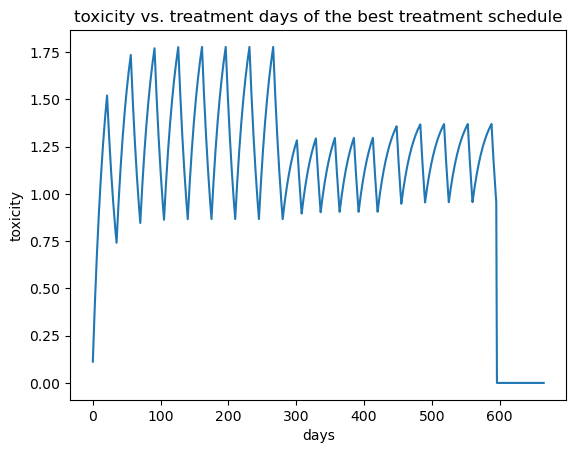

In [224]:
best_solution = sols[df_sp["score"].idxmax()]
plt.plot(best_solution["toxicity_sol"]);
plt.xlabel("days")
plt.ylabel("toxicity")
plt.title("toxicity vs. treatment days of the best treatment schedule");

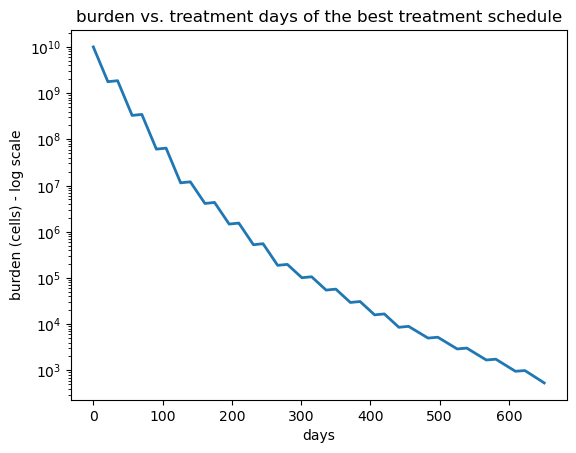

In [225]:
sol = sols[0]["burden_sol"]
plt.plot(sol .t, sol .y.T[:, 0], lw=2);
plt.xlabel("days")
plt.ylabel("burden (cells) - log scale")
plt.yscale("log")
plt.title("burden vs. treatment days of the best treatment schedule");